In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sm2
import statistics as stat
import time
from numpy.random import normal
import seaborn as sns
from scipy import optimize as opt
from scipy import stats as st
from risk_lib import psd,cov,simulation,VaR,ES


# Problem 1

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week05/Project/problem1.csv")

In [3]:
alpha=0.05
sample_size=10000

In [4]:
# Fit Normal Distribution VaR and ES, alpha=0.05
μ= df.mean()
σ = df.std()
VaR_norm = st.norm.ppf(alpha)*σ + μ
ES_norm = alpha**-1 * st.norm.pdf(st.norm.ppf(alpha))*σ - μ

# Fit Generalized T Distribution VaR and ES, alpha=0.05

data, mean ,scale=simulation.get_T_optParam(df)
VaR_t = scale * st.t.ppf(alpha, data)
simulated_T =  st.t.rvs(loc = mean,df = data,scale = scale,size = sample_size)
VaR_t_es = -np.percentile(simulated_T,5)
ES_t = (simulated_T[simulated_T < -VaR_t_es]).mean()
print("Alpha=0.05, Sample_Size=10000:")
print("")
print("VaR fitted with Normal distribution is: ", round(-VaR_norm[0]*100,2),"%")
print("ES fitted with Normal distribution  is: " ,round(ES_norm[0]*100,2),"%")
print("VaR fitted with T distribution is: ", round(-VaR_t*100,2),"%")
print("ES fitted with T distribution  is: " ,round(-ES_t*100,2),"%")

Alpha=0.05, Sample_Size=10000:

VaR fitted with Normal distribution is:  8.13 %
ES fitted with Normal distribution  is:  10.18 %
VaR fitted with T distribution is:  7.64 %
ES fitted with T distribution  is:  11.7 %


/Users/fredpeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/fredpeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(-0.3, 0.3)

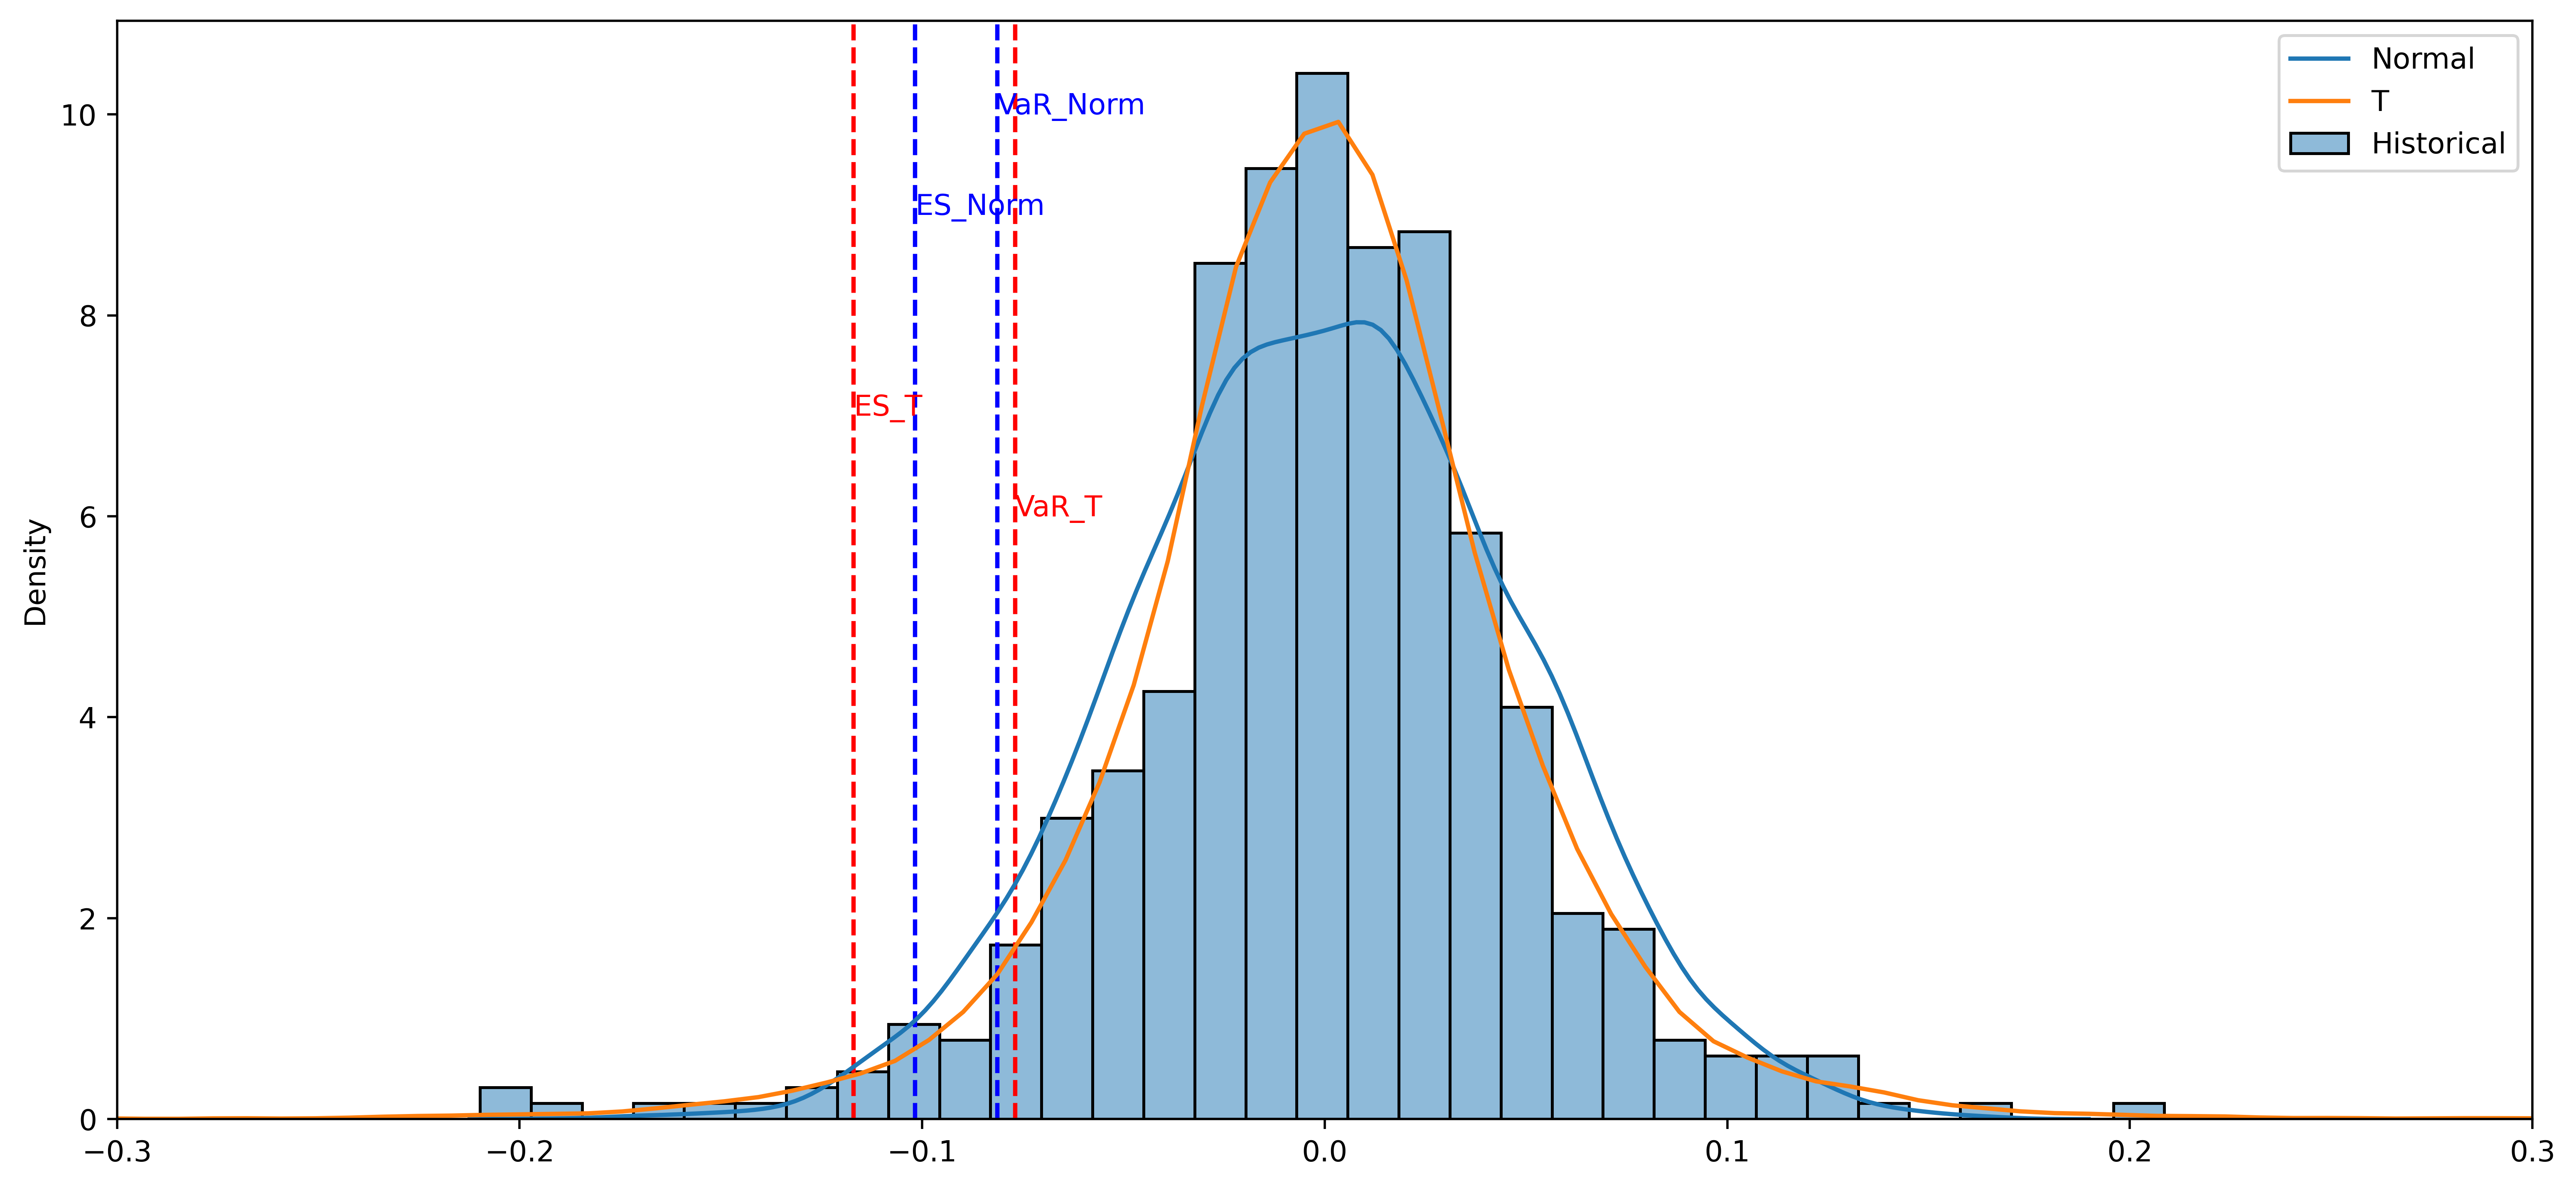

In [5]:
# LayOut
fig, axes = plt.subplots(figsize=(15,7),dpi=500)
simulated_norm =  st.norm.rvs(μ,σ,size = sample_size)
axes.axvline(x = -VaR_t_es, linestyle='dashed', color='red')
axes.axvline(x = ES_t, linestyle='dashed', color='red')
axes.text(x=-VaR_t_es, y=6, s='VaR_T', color='red')
axes.text(x=ES_t, y=7, s='ES_T', color='red')
axes.axvline(x = VaR_norm[0], linestyle='dashed',color="blue")
axes.axvline(x = -ES_norm[0], linestyle='dashed',color="blue")
axes.text(x=VaR_norm[0], y=10, s='VaR_Norm', color='blue')
axes.text(x=-ES_norm[0], y=9, s='ES_Norm', color='blue')
sns.histplot(df, stat='density',ax=axes, label='Historical', color='blue')
sns.distplot(simulated_norm, ax=axes, hist=False, label='Normal')
sns.distplot(simulated_T, ax=axes, hist=False, label='T')
axes.legend()
plt.xlim(-0.3,0.3)

# Problem 2

In [6]:
# PSD
sigma=np.array([[1.0,0.0,0.0,0.0,0.0],
                [0.9,1.0,0.9,0.9,0.9],
                [0.9,0.9,1.0,0.9,0.9],
                [0.9,0.9,0.9,1.0,0.9],
                [0.9,0.9,0.9 ,0.9 ,1.0]])

# test near_psd
n = 5
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357  
sigma[1, 0] = 0.7357  

res = psd.near_psd(sigma)
ans =  np.matrix([[1.0,       0.735701,  0.899997,  0.899997,  0.899997],
                  [0.735701,  1.0,       0.899997,  0.899997,  0.899997],
                  [0.899997,  0.899997,  1.0,       0.9,       0.9],
                  [0.899997,  0.899997,  0.9,       1.0,       0.9],
                  [0.899997,  0.899997,  0.9,       0.9,       1.0]])
print("near_psd test: ",abs(res - ans).sum() < 1e-5)
res = psd.higham_nearestPSD(sigma)
print("higham_nearestPSD test: ",abs(res - ans).sum() < 1e-4)
A = np.array([[2,-1,0], [-1,2,-1], [0,-1,2]])
print("chol_psd test: ",abs(np.linalg.cholesky(A) - psd.chol_psd(A)).sum() < 1e-8)
    


near_psd test:  True
higham_nearestPSD test:  True
chol_psd test:  True


In [7]:
# Cov
# Calculate the weighted Cov
d_t=pd.read_csv("https://raw.githubusercontent.com/Xupeiyi/Duke_Fintech590/main/tests/DailyReturnEwCov.csv")

cov_m = []
for l in [0.1, 0.3, 0.5,  0.90, 0.97]:
    # cov.weighted_cov is to create a weighted cov model
    cov_mat = cov.out_put_EWCM(df,l)
    cov_m.append(cov_mat)
cov_m


[array([[0.00020597]]),
 array([[0.0006001]]),
 array([[0.00088298]]),
 array([[0.00215641]]),
 array([[0.00220015]])]

In [8]:
#Sim
print(simulation.get_Norm_simulation(df, sample_size))
print(simulation.get_T_optParam(df))

[ 0.04741425  0.04391629 -0.03772227 ...  0.10055403  0.02199464
 -0.0461866 ]
(4.257039900012378, 0.0007922254434367344, 0.036451366198685685)


In [9]:
#VaR
VaR1 =VaR.VaR_normal(df, 0.05)
VaR2=VaR.VaR_EwNnormal(df, 0.05, 0.95)
VaR3=VaR.VaR_T(df, 0.05)
VaR4=VaR.VaR_His(df, 0.05)
print(VaR1,VaR2,VaR3,VaR4)


0.08045355289454788 0.08816295294436155 0.07558778082771055 0.07483740378386802


In [10]:
#ES
ES.ES(df, 0.05)

x    0.115903
dtype: float64

# Problem 3

In [12]:
portfolio = pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week05/Project/portfolio.csv")
prices = pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week05/DailyPrices.csv",index_col=0)
portfolio[portfolio["Portfolio"]=="A"]
summation = portfolio.groupby('Stock').sum('Holding')
summation['Portfolio'] = 'total'
summation.reset_index(inplace=True)
portfolio = portfolio.append(summation)
total_ret = prices.pct_change().dropna()
current = pd.DataFrame({"Price":prices.iloc[-1]})

VaR_S = []
ES_S = []
VaR_emp = []
ES_emp = []
for tag, value in portfolio.groupby('Portfolio'):
    value = value.set_index('Stock')
    value = value.join(current.loc[value.index])
    value['Value'] = value['Holding'] * value['Price']
    port_value = value['Value'].sum()
    Sim_ret = total_ret[value.index]
    ret_cop = simulation.copula(Sim_ret, 10000)
    loss=ret_cop*value['Value']
    Loss = loss.sum(axis=1)
    VaR_p = VaR.VaR_His(Loss,0.05)
    VaR_S.append(VaR_p)
    ES_p = ES.ES(Loss,0.05)
    ES_S.append(ES_p)
    his_return=value['Value']*total_ret[value.index]
    his_profitloss = his_return.sum(axis=1)
    VaR_h = VaR.VaR_His(his_profitloss,0.05)
    VaR_emp.append(VaR_h)
    ES_h = ES.ES(his_profitloss,0.05)
    ES_emp.append(ES_h)
    
    

/Users/fredpeng/Desktop/risk_lib/simulation.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret[col] -= ret[col].mean()
/Users/fredpeng/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/fredpeng/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
/Users/fredpeng/Desktop/risk_lib/simulation.py:18: RuntimeWarning: divide by zero encountered in log
  func = -np.log(st.t(df=param_vec[0], loc=param_vec[1], scale=param_vec[2]).pdf(x)).sum()


In [13]:
round(pd.DataFrame({"SimVaR":VaR_S,"SimES":ES_S,"Historical VaR":VaR_emp,
                    "Historical ES":ES_emp},index =["A","B","C","Total"]),2)

,SimVaR,SimES,Historical VaR,Historical ES
A,6033.02,7867.48,5329.25,7622.93
B,4735.39,6481.42,5579.83,7231.08
C,3835.51,5237.25,3320.22,4881.32
Total,14530.12,19563.65,12593.87,19735.33
